# Foundations of Computational Economics #19

by Fedor Iskhakov, ANU

<img src="_static/img/dag3logo.png" style="width:256px;">

## Measuring the volume of illegal trade with linear programming

<img src="_static/img/lab.png" style="width:64px;">

<img src="_static/img/youtube.png" style="width:65px;">

[https://youtu.be/4z7MU73cx0M](https://youtu.be/4z7MU73cx0M)

Description: Application of the optional transport problem.

### Application: measuring illegal trade

**“Black Market Performance: Illegal Trade in Beijing License Plates”**

by
Øystein Daljord, Mandy Hu, Guillaume Pouliot, Junji Xiao

*From abstract:*

We estimate the incentives to trade in the black market for license plates that emerged following the recent rationing of new car sales in Beijing by lottery. Under weak assumptions on car preferences, we use optimal transport methods and comprehensive data on car sales to estimate that at least 12% of the quota is illegally traded.

[PDF for the paper (right-click and Save as…)](_static/pdf/DaljordHuPouliotXiao2019.pdf)

#### Øystein Daljord (1979-2020)

<img src="_static/img/chicago-booth-oeystein-daljord.jpg" style="width:400px;">

#### Black market of license plates

- Measure the size of black market for license plates  
- Case of Beijing license plates regulation  
- Allocation by random lottery should have no effect on car sales  
- In reality, there is sizable shift in distribution of cars  
- Optimal transportation method is ideal to compute the lower bound on the volume of illegal trade of license plates  

#### Beijing license plate lottery

- Cars driving in Beijing are required to have Beijing license plates  
- From Jan 2011 license plates are rationed to a quota of about 35% of the previous year’s sales  
- License plates are allocated by a lottery with simple application  
- A Beijing household needs a license plate before it can register a new car  
- License plates are non-transferable  

#### Material shift in distribution of cars

- From cheaper to more expensive car models  
- Hard to explain if lottery is a truly random allocation of license plates to the car purchasers  
- No similar shifts in sales in comparable cities without rationing policy, in the same time period  
- No supply side responses to the rationing policy  

#### Modeling framework

Let $ \mathbb{P}_0 $ be the distribution of car sales prices from pre-lottery time,
and $ \mathbb{P}_1 $ the analogous distribution post-lottery.

Under assumptions

1. Pricing policy did not change between 2010 and 2011  
1. Demand structure did not change between 2010 and 2011  
1. Lottery is uniform  


the sales distributions should not change from the pre- to the post lottery period, i.e. $ \mathbb{P}_0 = \mathbb{P}_1 $

#### Data

Data on manufacturer suggested retail prices (MSRP) of the registered vehicles.

In [1]:
import pandas as pd
dt = pd.read_stata('_static/data/beijin_data.dta')
dt.dropna(inplace=True)  # drop rows with nan
print('Data has %d observations and %d variables'%tuple(dt.shape))  # print expects tuple
print(dt.head(n=10))

Data has 243677 observations and 3 variables
   year  month        MSRP
0  2010      9  153.313139
1  2010      9   44.543519
2  2011      2   88.812069
3  2010     11  210.732564
4  2011      4  101.591900
5  2010     12   56.428979
6  2011      1  140.571004
7  2010      8  170.066283
8  2011     11  111.935614
9  2010      7  191.988099


In [52]:
print(dt['MSRP'].describe())
q99 = dt['MSRP'].quantile(0.999)
dt = dt[dt['MSRP']<q99]
print(dt['MSRP'].describe())

count    241240.000000
mean        161.169630
std         102.551081
min          19.728006
25%          91.229416
50%         134.283479
75%         207.808600
max         617.902636
Name: MSRP, dtype: float64
count    240998.000000
mean        160.711504
std         101.577869
min          19.728006
25%          91.194088
50%         134.226738
75%         206.580364
max         616.711441
Name: MSRP, dtype: float64


In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

# plt.hist(dt.MSRP,bins=100,density=True,histtype='step');
# plt.show()


def plot2hist(d1,d2,bins=10,labels=['1','2']):
    '''Plots two overlapping histograms'''
    plt.hist(d1,bins=bins,density=True,histtype='step',label=labels[0])
    plt.hist(d2,bins=bins,density=True,histtype='step',label=labels[1])
    plt.legend()
    plt.show()

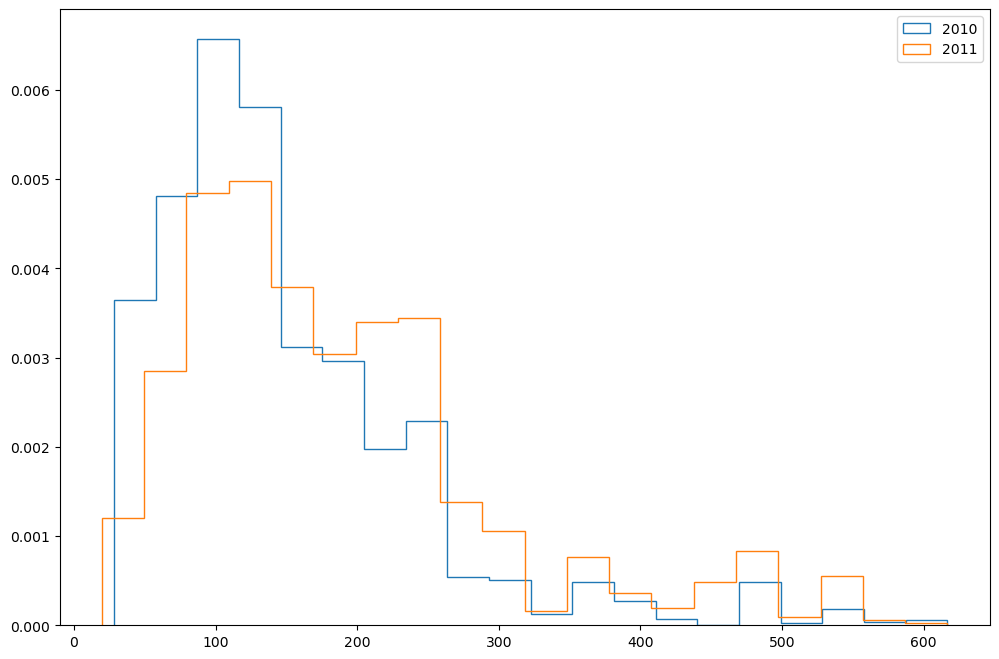

In [54]:
dt10 = dt[dt['year']==2010]['MSRP']
dt11 = dt[dt['year']==2011]['MSRP']
plot2hist(dt10,dt11,labels=['2010','2011'],bins=20)

#### Optimal transport problem

$$
\min \sum_{i=1}^{m}\sum_{j=1}^{n} cost_{ij} x_{ij}, \text{ subject to}
$$

$$
\sum_{i=1}^{m} x_{ij} = origin_j, j \in \{1,\dots,n\},
$$

$$
\sum_{j=1}^{n} x_{ij} = destination_i, i \in \{1,\dots,m\},
$$

$$
x_{ij} \ge 0 \text{ for all } i,j
$$

#### A linear programming problem

Linear programming problem solved by `scipy.optimize.linprog` (equality constraints automatically converted)

$$
\max(c \cdot x) \text{ subject to }
$$

$$
\begin{array}{l}
A_{ub}x \le b_{ub} \\
A_{eq}x = b_{eq} \\
l \le x \le u
\end{array}
$$

- stack all $ x_{ij} $ into a single vector  
- express equality constraints for origins and destinations as inequalities  


[https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html)

In [55]:
N = 20 # number of bins to represent the distribution
dt['bin'] = pd.qcut(dt.MSRP,q=N,labels=False)
gr10 = dt[dt['year']==2010].groupby('bin')
gr11 = dt[dt['year']==2011].groupby('bin')
d10 = gr10.MSRP.count()/dt[dt['year']==2010]['year'].count()
d11 = gr11.MSRP.count()/dt[dt['year']==2011]['year'].count()
# set up optimal transport problem
import numpy as np
costs = np.ones((N,N)) - np.eye(N)
origins = np.array(d10)
destinations=np.array(d11)
# print(costs,orgins,destinations,sep='\n')
#represent transport problem as linear programming
c = costs.reshape(N*N)
A1=np.kron(np.ones((1,N)),np.eye(N))
A2=np.kron(np.eye(N),np.ones((1,N)))
A=np.vstack((A1,A2))
b=np.concatenate((origins, destinations))
# plt.spy(A)
# linear programming solver
from scipy.optimize import linprog
res = linprog(c=c,A_eq=A[:-1],b_eq=b[:-1],method='simplex')
x=res.x.reshape((N,N))
# print(x,x.sum())
# plt.spy(x)
estimate = 1 - np.diag(x).sum()
print('The lower bound on the share of illegal trade is {:1.5f}% of total trade'.format(estimate*100))
# print(res)

The lower bound on the share of illegal trade is 18.83435% of total trade


C:\Users\rudol\AppData\Local\Temp\ipykernel_4660\3886353177.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt['bin'] = pd.qcut(dt.MSRP,q=N,labels=False)
C:\Users\rudol\AppData\Local\Temp\ipykernel_4660\3886353177.py:22: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  res = linprog(c=c,A_eq=A[:-1],b_eq=b[:-1],method='simplex')


In [34]:
np.ones((1,N))

array([[1., 1., 1., 1., 1.]])

In [36]:
np.eye(N)

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [ ]:
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
# Answer below

In [ ]:
N = 5  # number of bins to represent distribution
dt['gr'] = pd.qcut(dt.MSRP,q=N,labels=False)  # N quantiles
gr10 = dt[dt.year==2010].groupby('gr')
gr11 = dt[dt.year==2011].groupby('gr')
d10 = gr10.MSRP.count()/dt[dt.year==2010].MSRP.count()
d11 = gr11.MSRP.count()/dt[dt.year==2011].MSRP.count()
print(d10,d11,sep='\n\n')

In [ ]:
import numpy as np
# Set up transportation problem
costs = np.ones((N,N)) - np.eye(N)  # costs matrix
origins = np.array(d10)        # origins
destinations = np.array(d11)   # destinations
plt.rcParams['figure.figsize'] = [5, 5]
plt.spy(costs)

In [ ]:
# convert to linear programming problem
C = costs.reshape(N*N)
A1 = np.kron(np.eye(N),np.ones((1,N)))  # sums of x for each origin
A2 = np.kron(np.ones((1,N)),np.eye(N))  # sums of x for each destination
A = np.vstack((A1,A2))  # concatenate vertically
plt.spy(A)
b = np.concatenate((origins,destinations))

In [ ]:
# Solve the transportation problem
from scipy.optimize import linprog
res = linprog(c=C,A_eq=A[:-1],b_eq=b[:-1],bounds=(0,None),method='simplex')
print(res.message)
X = res.x.reshape((N,N)) # reshape back to X_ij
plt.spy(X)
print(X)
black_market_estim = 1 - np.diag(X).sum() # do not count the stationary diagonal
print('With N=%d the lower bound on black market share is %1.5f'%(N,black_market_estim))

#### Displacement of the car sales distributions

- Main result: significant evidence for a sizable black market share!  
- Computed the **lower boundary** on the fraction of illegal trade (why?)  
- Grain of salt: this is one of possible mechanisms, need to eliminate other possible routes (see the paper)  
- What robustness checks should be run? Technical parameter $ N $ clearly affects the numerical result  

### Further learning resources

- Full paper
  [https://www.jstor.org/stable/j.ctt1q1xs9h](https://www.jstor.org/stable/j.ctt1q1xs9h)  
- [PDF for the paper (right-click and Save as…)](_static/pdf/DaljordHuPouliotXiao2019.pdf)  